In [ ]:
# Computer Vision: project - Car speed detection in Kugel square

Submitted by: [ **... Ilana Bercovich 316161603  & Lina Koz 321003170... & Tomer Shemesh 206244618 ** ]

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import copy
print(cv2.__version__)


4.4.0


# Croping the original video

In [4]:
cap = cv2.VideoCapture('P2_Kugel.mov')

FPS = cap.get(cv2.CAP_PROP_FPS)
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')

out = cv2.VideoWriter('P2_Kugel_croped.mp4', fourcc, FPS, (500, 252))
while(1):
    ret,frame = cap.read()
    if ret==True:
        crop_img = frame[80:332, 80:580]
        cv2.imshow('croped',crop_img)
        out.write(crop_img)
        k = cv2.waitKey(1) & 0xff
        if k == 27:
            break
    else:
        break
cv2.destroyAllWindows()
cap.release()
cv2.waitKey(1)
out.release()    

# Showing good features to track

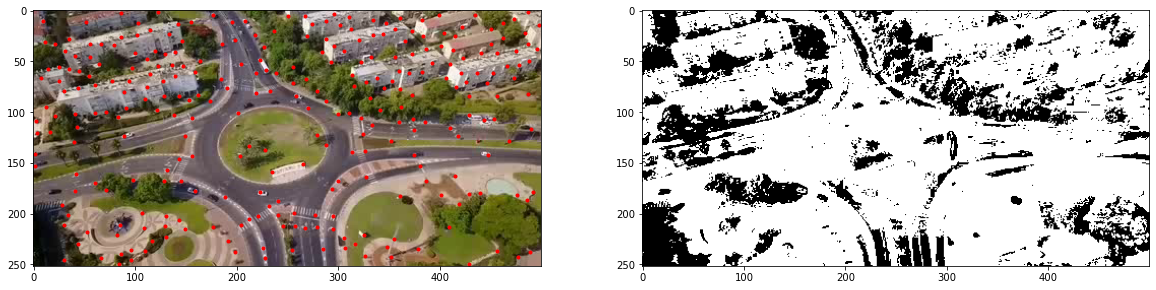

In [17]:
# params for ShiTomasi corner detection
feature_params = dict(maxCorners = 1000, qualityLevel = 0.1, minDistance = 10, blockSize = 5)

# Parameters for lucas kanade optical flow
lk_params = dict(winSize  = (10, 10), maxLevel = 2, criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.01))

cap = cv2.VideoCapture('P2_Kugel_croped.mp4')
ret, frame_1 = cap.read()
ret, frame_2 = cap.read()
cap.release()
old_frame = frame_1.copy()
frame_bgr = frame_2.copy()
gray_1 = cv2.cvtColor(frame_1, cv2.COLOR_BGR2GRAY)
gray_2 = cv2.cvtColor(frame_2, cv2.COLOR_BGR2GRAY)

mask = cv2.threshold(gray_1, 80, 255, cv2.THRESH_BINARY)[1]


prev_pts = cv2.goodFeaturesToTrack(gray_1, mask = mask, **feature_params)

cur_pts, status, err = cv2.calcOpticalFlowPyrLK(gray_1, gray_2, prev_pts, None, **lk_params)

good_old = prev_pts[status[:, 0] == 1]
good_new = cur_pts[status[:, 0] == 1]

plt.figure(figsize = (20, 16))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(frame_1, cv2.COLOR_BGR2RGB))
plt.plot(good_new[:, 0, 0], good_new[:, 0, 1], '.r')

plt.subplot(1, 2, 2)
plt.imshow(mask,cmap='gray')

plt.show()

# Creating hitmap of cars speed

In [ ]:
cap = cv2.VideoCapture('P2_Kugel_croped.mp4')
counter=0

FPS = cap.get(cv2.CAP_PROP_FPS)
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')

out = cv2.VideoWriter('project_hitmap2.mp4', fourcc, FPS, (W, H))

# params for corner detection
feature_params = dict( maxCorners = 5000,
                       qualityLevel = 0.01,
                       minDistance = 35,
                       blockSize = 5 )

# Parameters for optical flow
lk_params = dict( winSize  = (25,25),
                  maxLevel = 5,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))


# Take first frame and find corners in it
ret, F0 = cap.read()
F0_gray = cv2.cvtColor(F0, cv2.COLOR_BGR2GRAY)
pts0 = cv2.goodFeaturesToTrack(F0_gray, mask = None, **feature_params)

                   
# Create a mask image for drawing purposes
canvas = np.zeros_like(F0)
plt.imshow(F0_gray)

while(1):
    ret,F1 = cap.read()
    
    if ret==True:    
        F1_gray = cv2.cvtColor(F1, cv2.COLOR_BGR2GRAY)
        # calculate optical flow
        pts1, status, err = cv2.calcOpticalFlowPyrLK(F0_gray, F1_gray, pts0, None, **lk_params)
        
        # delete "failed" points (status==0)
        status = status.flatten()
        pts1 = pts1[status==1]
        pts0 = pts0[status==1]
        
        for (p0,p1) in zip(pts0,pts1):
            x0,y0 = p0.squeeze().astype(np.int)
            x1,y1 = p1.squeeze().astype(np.int)
            v1 = x1 - x0
            v2 = y1 - y0
            abs_v1 = abs(v1)
            abs_v2 = abs(v2)
            

            if ( 2 > abs_v1 > 0) or  ( 2 > abs_v2 > 0) :
                canvas = cv2.line(canvas,(x0,y0),(x1,y1),(255,0,0),2)
            elif ( 6 > abs_v1 > 2 ) or  ( 6 > abs_v2 > 2) :
                canvas = cv2.line(canvas,(x0,y0),(x1,y1),(0,255,255),2)
            elif ( 20 > abs_v1 > 6 ) or  ( 20 > abs_v2 > 6) :
                canvas = cv2.line(canvas,(x0,y0),(x1,y1),(0,255,0),2)
            
        
        # visualize the results
        final = cv2.add(F1, canvas)
        cv2.imshow('final',final)
        out.write(canvas) 
        counter += 1
        # find new features to track: 
        tracking_mask = np.zeros_like(F1_gray) + 255
        if (counter%25)==0: 
            new_pts = cv2.goodFeaturesToTrack(F1_gray, mask = tracking_mask, **feature_params)
            if new_pts is not None:
                n = new_pts.size//2 
                pts1 = np.vstack((pts1,new_pts))        
        # Now update the previous frame and previous points
        F0_gray = F1_gray
        pts0 = pts1
         
        k = cv2.waitKey(1) & 0xff
        if k == 27:
            break
            
    else: 
        break

cv2.destroyAllWindows()
cap.release()
cv2.waitKey(1)
out.release()
hitmap_canvas = canvas

# Finding contours that move from frame 1 to frame 2

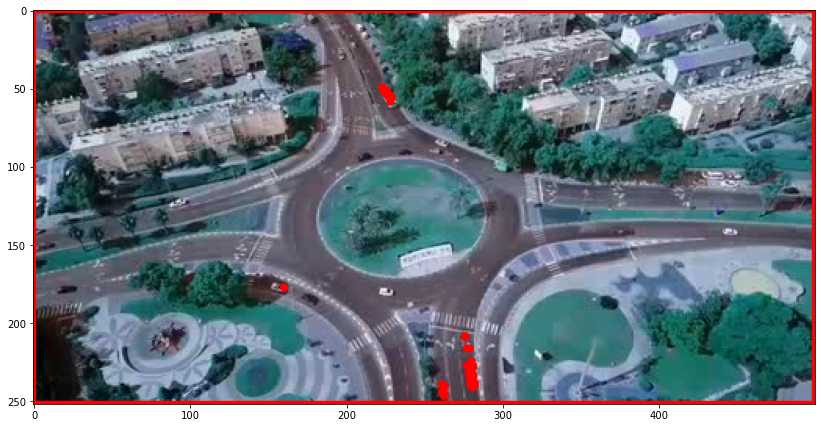

In [62]:
cap = cv2.VideoCapture('P2_Kugel_croped.mp4')


ret, F0 = cap.read()
cap.set(1,50);
ret, F1 = cap.read()


F0_gray = cv2.cvtColor(F0, cv2.COLOR_BGR2GRAY)
F1_gray = cv2.cvtColor(F1, cv2.COLOR_BGR2GRAY)


K = np.zeros((19,19), dtype=np.uint8)
K[2,:]=1
K[:,2]=1
img_filt = cv2.filter2D(F0_gray, -1, K/K.sum())

F_dif = cv2.absdiff(F0_gray,F1_gray)
ret,img_mask = cv2.threshold(F_dif,180,255,cv2.THRESH_BINARY_INV)



rgb = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2RGB)
ctrs, hierarchy = cv2.findContours(img_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(F0, ctrs, -1, (255, 0, 0), 2)


plt.figure(figsize=(14,8))
plt.imshow(F0)



 

# Creating video with all the cars contours

In [8]:
cap = cv2.VideoCapture('P2_Kugel_croped.mp4')

FPS = cap.get(cv2.CAP_PROP_FPS)
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('project_contours.mp4', fourcc, FPS, (W, H))

ret, F0 = cap.read()
F0_blur = cv2.GaussianBlur(F0, (3,3), 0)
F_prev = cv2.cvtColor(F0_blur, cv2.COLOR_BGR2GRAY)
canvas = np.zeros_like(F0)

while True :
    ret,frame = cap.read()
    if ret==True:
        canvas = np.zeros_like(F0)
        F1_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        F1_gray = cv2.GaussianBlur(F1_gray, (5,5), 0)
        dif_frame = cv2.absdiff(F_prev,F1_gray)
        thresh = cv2.adaptiveThreshold(dif_frame,100,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,3,-20)
        dilated = cv2.dilate(thresh, None, iterations = 2)
        ctrs, hierarchy = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for c in ctrs:
            cv2.drawContours(canvas, [c], -1, (0,0,255), 2)
            cv2.drawContours(frame, [c], -1, (0,0,255), 2)                
        cv2.imshow('final',frame)    
        out.write(canvas)
        F_prev = F1_gray
        
        k = cv2.waitKey(1) & 0xff
        if k == 27:
            break
    else:
        break
           
cv2.destroyAllWindows()
cap.release()
cv2.waitKey(1)
out.release()
contour_canvas = canvas

# Combining the heatmap and contours to the original video

In [7]:
cap = cv2.VideoCapture('P2_Kugel_croped.mp4')
hitmap_cap = cv2.VideoCapture('project_hitmap.mp4')
contour_cap = cv2.VideoCapture('project_contours.mp4')

FPS = cap.get(cv2.CAP_PROP_FPS)
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')

out = cv2.VideoWriter('project_final.mp4', fourcc, FPS, (W, H))

while True :
    ret,frame = cap.read()
    hm_ret, hm_frame = hitmap_cap.read()
    contour_ret, contour_frame = contour_cap.read()
    if ret==True and hm_ret == True and contour_ret == True:
        # visualize the results
        final = cv2.add(frame, hm_frame)
        final = cv2.add(final,contour_frame)
        cv2.imshow('final',final)
        out.write(final)
        k = cv2.waitKey(1) & 0xff
        if k == 27:
            break
    else:
        break
           
cv2.destroyAllWindows()
cap.release()
cv2.waitKey(1)
out.release()